# A Forum-based Chatbot for Parents of Autistic Children

**[Khalil Mrini](https://goo.gl/7MCYvq)**

# Table of Contents

### [1. Scraping the Online Forum](#1)
[1.1. Functions](#11) <br/>
[1.2. Collected Data](#12) <br/>
[1.2.1. Parents' Discussion](#121) <br/>
[1.2.2. General Autism Discussion](#122) <br/>
[1.3. Filtering Data](#13) <br/>

### [2. Amazon Mechanical Turk](#2)
[2.1. Sampling Threads](#21) <br/>
[2.2. Using sent2vec to Cluster Samples](#22) <br/>
[2.3. Checking Amazon Mechanical Turk Results](#23) <br/>
[2.4. Using NLTK to Separate Text Data into Sentences](#24) <br/>
[2.4.1. For the Samples](#241) <br/>
[2.4.2. For All Collected Data](#242) <br/>

### [3. Machine Learning Features](#3)
[3.1. MTurk DataFrame](#31) <br/>
[3.2. Adding Reply Vectors](#32) <br/>
[3.3. Adding First Post Vectors](#33) <br/>
[3.4. Adding Title Vectors](#34) <br/>
[3.5. Computing sent2vec Similarity](#35) <br/>
[3.6. Adding Features from Forum Threads](#36) <br/>
[3.7. Standardization of Features](#37) <br/>
[3.8. Train and Test Data Sets](#38) <br/>
[3.9. PCA Visualization](#39) <br/>

### [4. Ensemble Classifiers for Multi-Class Labels](#4)
[4.1. Random Forest Classifier](#41) <br/>
[4.2. Bagging Classifier](#42) <br/>
[4.3. Ada Boost Classifier](#43) <br/>
[4.4. Extra Trees Classifier](#44) <br/>
[4.5. Gradient Boosting Classifier](#45) <br/>
[4.6. SVM](#46) <br/>
[4.7. Decision Tree Classifier](#47) <br/>
[4.8. K-Neighbours Classifier](#48) <br/>
[4.9. Radius Neighbours Classifier](#49) <br/>

### [5. Building the Chatbot](#5)
[5.1. Applying the Model to All Unlabelled Replies](#51) <br/>
[5.2. Precomputing word2vec](#52) <br/>
[5.3. Dot Product Similarity Functions](#53) <br/>
[5.4. Chatbot Functions](#54) <br/>

# 1. Scraping the Online Forum <a class="anchor" id="1"></a>

In this section, we scrape the online forum [Wrong Planet](https://wrongplanet.net/forums/) for posts in the *General Autism Discussion* and the *Parents' Discussion*.

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import nltk
import gensim

## 1.1. Functions <a class="anchor" id="11"></a>

In [1]:
def find_next(soup):
    """
    Tries to find next page, or returns an empty string if there is no next page.
    :param soup: BeautifulSoup
    :return: string
    """
    try:
        return soup.find_all('a', string="Next")[0]['href'][1:]
    except:
        return ""

def find_all_rows(soup, type_name):
    """
    Finds all rows of a soup with the given type name.
    :param soup: BeautifulSoup
    :param type_name: string
    :return: list
    """
    try:
        return soup.find_all(type_name, {'class': 'row'})
    except:
        return []

def convert_to_int(text):
    """
    Converts string to integer by eliminating non-digit characters.
    :param text: string
    :return: int
    """
    return int(''.join([char for char in text if char.isdigit()]))

def transform_datetime(datetime):
    """
    Removes mentions of Yesterday and Today.
    """
    try:
        return datetime.replace('Yesterday', '24 Oct 2017').replace('Today', '25 Oct 2017')
    except:
        return datetime

def collect_forum_data(soup_row, link=""):
    """
    Collects all relevant data (title, link, text, number of replies and views) of a thread.
    :param soup_row: BeautifulSoup
    :param link: string
    :return: dict
    """
    data = {}
    try:
        title_soup = soup_row.find('h4').find('a')
        data['Title'] = title_soup.text.strip()
        data['Link'] = title_soup['href'][1:]
        info_soup = soup_row.find_all('td', {'class': 'count-col'})
        for info in info_soup:
            info_text = info.text.strip()
            info_number = convert_to_int(info_text)
            if 'repl' in info_text:
                data['Replies'] = info_number
            if 'view' in info_text:
                data['Views'] = info_number
    except:
        pass
    return data

def collect_post_data(soup_row, link=""):
    """
    Collects all relevant data of a post.
    :param soup_row: BeautifulSoup
    :param link: string
    :return: dict
    """
    data = {}
    try:
        data['Link'] = link.replace(PREFIX_URL, '')
        user_soup = soup_row.find('div', class_='user-col').find_all('p')
        for element in str(user_soup[-1])[3:-4].strip().split('<br/>'):
            elements = element.split(': ')
            if len(elements) == 2:
                if elements[0] == "Joined":
                    data[elements[0]] = transform_datetime(elements[1])
                else:
                    data[elements[0]] = elements[1]
        try:
            data['Username'] = user_soup[0].text.strip().split('\n')[0]
        except:
            pass
        try:
            data['User Level'] = convert_to_int(user_soup[0].find('img')['src'])
        except:
            pass
        message_soup = soup_row.find('div', class_='message-col')
        data['Timestamp'] = transform_datetime(message_soup.find('div', class_='timestamp').text.strip())
        data['Message'] = message_soup.find('div', class_='message-content').text.strip()
    except:
        pass
    return data

def collect_recursively(data, url, type_name, data_function, index=""):
    """
    Collects data recursively using a collection function from the two above.
    :param data: dict
    :param url: string
    :param type_name: string
    :param data_function: function
    :param index: string
    :return: dict
    """
    try:
        if index:
            print(index, end='\r', flush=True)
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
        soup_rows = find_all_rows(soup, type_name)
        data.extend([data_function(soup_row, link=url) for soup_row in soup_rows])
        next_url = find_next(soup)
        if next_url:
            if index:
                return collect_recursively(data, PREFIX_URL + next_url, type_name, data_function, index+1)
            else:
                return collect_recursively(data, PREFIX_URL + next_url, type_name, data_function)
        else:
            return data
    except:
        return data

def get_forum_dataframe(url, type_name, data_function):
    """
    Launches process to collect a dataframe for all threads of a forum.
    :param url: string
    :param type_name: string
    :param data_function: function
    :return: DataFrame
    """
    data = collect_recursively([], url, type_name, data_function, 1)
    return pd.DataFrame(data)

def get_thread_dataframe(forum_df, type_name, data_function):
    """
    Launches process to collect a dataframe for all posts of a thread.
    :param forum_df: DataFrame
    :param type_name: string
    :param data_function: function
    :return: DataFrame
    """
    data = []
    total = len(forum_df['Link'])
    index = 0
    for url in forum_df['Link']:
        index += 1
        print('{} out of {}'.format(index, total), end='\r', flush=True)
        data.extend(collect_recursively([], PREFIX_URL + url, type_name, data_function))
    return pd.DataFrame(data)

## 1.2. Collected Data <a class="anchor" id="12"></a>

### 1.2.1. Parents' Discussion <a class="anchor" id="121"></a>

We collect the data in DataFrames:

In [2]:
PREFIX_URL = 'http://wrongplanet.net/forums'
START_URL = PREFIX_URL + '/viewforum.php?f=19'

In [ ]:
forum_df = get_forum_dataframe(START_URL, 'tr', collect_forum_data)
forum_df.to_json('Forum Data/parents_forum.json')

In [ ]:
thread_df = get_thread_dataframe(forum_df, 'div', collect_post_data)

We merge the thread titles with the corresponding posts and save them in *json* format:

In [ ]:
parents_df = pd.merge(thread_df, forum_df, on='Link')
parents_df.to_json('Forum Data/parents_forum_threads.json')

### 1.2.2. General Autism Discussion <a class="anchor" id="122"></a>

We do the same for the *General Autism Discussion*:

In [7]:
GENERAL_URL = 'http://wrongplanet.net/forums/viewforum.php?f=3'
general_forum_df = get_forum_dataframe(GENERAL_URL, 'tr', collect_forum_data)
general_forum_df.to_json('Forum Data/general_forum.json')
general_forum_df.head()

,Link,Replies,Title,Views
0,/viewtopic.php?t=73832&sid=90b20b008fa46184b87...,0,WrongPlanet Rules. You must read this before p...,24985
1,/viewtopic.php?t=102721&sid=90b20b008fa46184b8...,2398,First time in history!! !! The NT/AS open hotl...,670346
2,/viewtopic.php?t=114120&sid=90b20b008fa46184b8...,281,autism reality documentary,590556
3,/viewtopic.php?t=112787&sid=90b20b008fa46184b8...,655,greenturtle74’s Cartoon Guide to Asperger’s,667480
4,/viewtopic.php?t=187047&sid=90b20b008fa46184b8...,224,"Autism in France: Psychoanalysis, Packing, Oth...",210364


In [10]:
general_thread_df = get_thread_dataframe(general_forum_df, 'div', collect_post_data)
general_thread_df.head()

,Age,Gender,Joined,Link,Location,Message,Posts,Timestamp,User Level,Username
0,33,Male,27 Sep 2011,/viewtopic.php?t=297204&sid=90b20b008fa46184b8...,NaN,"One common mistake people make, even on Wrong ...",724,"01 Nov 2015, 12:00 pm",5.0,Comp_Geek_573
1,NaN,Female,16 Mar 2013,/viewtopic.php?t=297204&sid=90b20b008fa46184b8...,Earth,http://www.cdc.gov/ncbddd/autism/hcp-dsm.html,"2,173","01 Nov 2015, 12:03 pm",5.0,iliketrees
2,49,Female,1 Jul 2009,/viewtopic.php?t=297204&sid=90b20b008fa46184b8...,"Los Angeles, CA",How would any of us define autism outside of t...,499,"01 Nov 2015, 2:01 pm",4.0,NowhereWoman
3,26,NaN,19 Jun 2015,/viewtopic.php?t=297204&sid=90b20b008fa46184b8...,Wyoming,That is a good point it is a spectum on severa...,81,"01 Nov 2015, 2:24 pm",1.0,GreenPandaLord
4,28,Female,14 Oct 2008,/viewtopic.php?t=85651&sid=90b20b008fa46184b87...,Nowhere,"No this post is not bashing all neurotypicals,...",894,"14 Dec 2008, 9:17 pm",5.0,timeisdead


In [ ]:
general_merged_df = pd.merge(general_thread_df, general_forum_df, on='Link')
general_merged_df.to_json('general_forum_threads.json')

## 1.3. Filtering Data <a class="anchor" id="13"></a>

In this subsection, we filter the threads to only keep those having questions as titles.

In [2]:
forum_threads = pd.concat([pd.read_json('general_forum_threads.json'), 
                           pd.read_json('parents_forum_threads.json')]).reset_index(drop=True)
forum_subjects = pd.concat([pd.read_json('general_forum.json'), 
                            pd.read_json('parents_forum.json')]).reset_index(drop=True)
forum_threads.Link = forum_threads.Link.apply(lambda row: row.split('t=')[1].split('&')[0])
forum_threads.Message = forum_threads.Message.apply(lambda msg: msg.split('_________________')[0])
forum_subjects.Link = forum_subjects.Link.apply(lambda row: row.split('t=')[1].split('&')[0])
forum_subjects = forum_subjects.drop_duplicates(subset=['Link'], keep='first')
forum_threads = forum_threads.drop_duplicates(subset=['Link', 'Message'], keep='first')
forum_threads.to_json('forum_threads.json')
forum_subjects.to_json('forum_subjects.json')

The total number of posts is:

In [3]:
len(forum_threads)

701337

The total number of threads is:

In [4]:
len(forum_subjects)

82383

The following function defines what is a question:

In [5]:
def is_question(sentence):
    """
    Returns true if a sentence is a question.
    :param sentence: list of strings, the sentence is tokenized
    :return: boolean
    """
    new_sentence = (''.join([c for c in sentence if c.isalnum() or c in '?!./ "\''])).replace('/', ' ')
    tokens = nltk.word_tokenize(new_sentence)
    tokens = [word[:1].lower() + word[1:] for word in tokens]
    try:
        question_mark_index = tokens.index('?')
        if question_mark_index == len(tokens) - 1:
            tags = nltk.pos_tag(tokens[:question_mark_index + 1])
            if tags[0][1] in 'MD VB VBD VBN VBP VBZ WRB WP WDT'.split(' ') and tags[0][0] not in 'am'.split(' '):
                for tag in tags:
                    if tag[1].startswith('VB'):
                        return True
    except:
        pass
    return False

In [6]:
filtered_forum_subjects = forum_subjects[forum_subjects['Title'].map(lambda x: is_question(x))]
len(filtered_forum_subjects)

15708

In [7]:
filtered_forum_subjects.head()

,Link,Replies,Title,Views
9,287074,18,Are you a multipotentialite?,1176
11,293067,9,Why is my performance IQ so low?,979
17,293065,13,Are individuals with Autism often taller than ...,572
19,293055,8,Do you ever wonder if NT people are missing out?,356
20,292656,33,Does your diagnosis make you feel like a speci...,1365


In [8]:
merged_forum_threads = pd.merge(forum_threads.drop(['Views', 'Replies', 'Title'], axis=1), forum_subjects, 
                                on='Link', how='inner')
merged_forum_threads.to_json('merged_forum_threads.json')
merged_forum_threads.head()

,Age,Gender,Joined,Link,Location,Message,Posts,Timestamp,User Level,Username,Replies,Title,Views
0,17.0,Female,1.33989e+12,287074,None,Can anyone else relate to this video?\n,346,1432979760000,4.0,physicsnut42,18,Are you a multipotentialite?,1176
1,NaN,Male,1.39147e+12,287074,"Queens, NYC",Yep...I believe people should make use of all ...,"37,484",1432981020000,5.0,kraftiekortie,18,Are you a multipotentialite?,1176
2,34.0,Male,1.27293e+12,287074,was Louisiana but now Vermont,I'm not. I never had many interests.\n,"17,363",1432999500000,5.0,nick007,18,Are you a multipotentialite?,1176
3,NaN,Male,1.42033e+12,287074,Europe,Like physicsnut I can relate to this video. I'...,956,1433163360000,5.0,Hyperborean,18,Are you a multipotentialite?,1176
4,18.0,Male,1.39242e+12,287074,Australia,"To an extent...I have 3 main interests, music,...","2,879",1433057160000,5.0,Outrider,18,Are you a multipotentialite?,1176


In [9]:
len(merged_forum_threads)

701337

In [10]:
titles_with_first_post = merged_forum_threads.groupby('Link').first().reset_index()[['Link', 'Title', 'Username', 'Message', 'Replies']]
titles_with_first_post.columns = ['Link', 'Title', 'Seeker', 'First Post', 'Replies']
titles_with_first_post.head()

,Link,Title,Seeker,First Post,Replies
0,100003,"Okay, so what's up with this no gluten or milk...",wigglyspider,"I can't find any info about it for adults, it'...",45
1,100005,Who has DESPERATELY tried to fit in at times i...,millie,Pondering this came out of a consideration of ...,55
2,100007,Getting Diagnosed?,Toco,"Hey guys, I've just joined, and posted an intr...",8
3,100020,"Stimming, nervous habit, or other?",fiddlerpianist,"So I've done this ""thing"" since I was fairly l...",16
4,100044,AS / HFA / PDD-NOS ???,littlemissfickle,i have always known there is something wrong w...,3


In [11]:
len(titles_with_first_post)

36659

In [12]:
len(merged_forum_threads.Link.unique())

36659

In [13]:
len(forum_threads.Link.unique())

36659

In [14]:
links = list(forum_subjects.Link)
other = set(forum_threads.Link.unique())
excluded_titles = [link for link in links if link not in other]
len(excluded_titles)

45724

In [15]:
titles = set(filtered_forum_subjects['Title'])
filter_titles_with_first_post = titles_with_first_post[titles_with_first_post['Title'].map(lambda x: x in titles)]
len(filter_titles_with_first_post)

15684

In [16]:
first_post_lengths = filter_titles_with_first_post['First Post'].map(lambda x: len(x))
first_post_lengths.describe()

count    15684.000000
mean       854.645754
std       1101.757246
min          0.000000
25%        261.000000
50%        547.000000
75%       1052.250000
max      33687.000000
Name: First Post, dtype: float64

In [17]:
filtered_forum_subjects.Replies.describe()

count    15708.000000
mean        23.662592
std         26.113242
min          0.000000
25%          8.000000
50%         17.000000
75%         31.000000
max        883.000000
Name: Replies, dtype: float64

In [18]:
max_len = 1053
min_reply = 8
filter_titles_with_first_post = filter_titles_with_first_post[filter_titles_with_first_post['Replies'].map(lambda x: x >= min_reply)]
filter_titles_with_first_post = filter_titles_with_first_post[filter_titles_with_first_post['First Post'].map(lambda x: len(x) <= max_len)]
len(filter_titles_with_first_post)

9347

In [19]:
titles_with_messages = pd.merge(filter_titles_with_first_post.drop(['Replies'], axis=1), merged_forum_threads[['Username', 'Message', 'Link']], on='Link')
titles_with_messages.rename(columns={'Username':'Replier'}, inplace=True)
titles_with_messages = titles_with_messages[titles_with_messages.apply(lambda row: not row['First Post'] == row['Message'] and not row['Seeker'] == row['Replier'], axis=1)]
titles_with_messages.head()

,Link,Title,Seeker,First Post,Replier,Message
2,100058,How Do YOU Hold Your Glass?,KarmicPyxis,What do you think of http://news.bbc.co.uk/2/h...,Justin6378,"I hold my glass with both hands, for fear of s..."
3,100058,How Do YOU Hold Your Glass?,KarmicPyxis,What do you think of http://news.bbc.co.uk/2/h...,typ3,Whut. I occasionally do all of those positions...
5,100058,How Do YOU Hold Your Glass?,KarmicPyxis,What do you think of http://news.bbc.co.uk/2/h...,KingdomOfRats,"do not use a glass,am hold cups/cans/bottles i..."
6,100058,How Do YOU Hold Your Glass?,KarmicPyxis,What do you think of http://news.bbc.co.uk/2/h...,1234,"my pinky sticks out, like those posh people ho..."
7,100058,How Do YOU Hold Your Glass?,KarmicPyxis,What do you think of http://news.bbc.co.uk/2/h...,Lecks,"1234 wrote:my pinky sticks out, like those pos..."


In [20]:
len(titles_with_messages)

260880

In [21]:
len(titles_with_messages.Link.unique())

9346

In [31]:
file = open('text.txt', 'w')
[print(title, file=file) for title in filter_titles_with_first_post.Title]
file.close()

# 2. Amazon Mechanical Turk <a class="anchor" id="2"></a>

## 2.1. Sampling Threads <a class="anchor" id="21"></a>

In this subsection, we sample threads which replies will be labelled in Amazon Mechanical Turk.

In [22]:
sample_titles = set(filter_titles_with_first_post.sample(frac=0.04)['Title'])
sample_titles_with_messages = titles_with_messages[titles_with_messages['Title'].map(lambda x: x in sample_titles)]
sample_titles_with_messages = sample_titles_with_messages[sample_titles_with_messages.Message.map(lambda x: len(x) <= max_len)]
sample_titles_with_messages.head()

,Link,Title,Seeker,First Post,Replier,Message
348,100346,What are your favorites foods - how often do y...,AspieCard,I have several favorite meals.\n\nMy favorite ...,Spokane_Girl,Macaroni and Cheese. I will cook it for dinner...
349,100346,What are your favorites foods - how often do y...,AspieCard,I have several favorite meals.\n\nMy favorite ...,Xs142,"Pancakes,\ndaily,\ngirlfriend threw me out of ..."
350,100346,What are your favorites foods - how often do y...,AspieCard,I have several favorite meals.\n\nMy favorite ...,AJCoyne,CHOCOLATE! !! !\n \nI am a chocolate MONSTE...
352,100346,What are your favorites foods - how often do y...,AspieCard,I have several favorite meals.\n\nMy favorite ...,millie,Many people with ASD's tend towards a restrict...
353,100346,What are your favorites foods - how often do y...,AspieCard,I have several favorite meals.\n\nMy favorite ...,wigglyspider,I liiiike...\n\nCalamari with garlic aioli sau...


In [23]:
sample_titles_with_messages.to_csv('amazon_mechanical_turk.csv', index=False)
len(sample_titles_with_messages)

9288

In [24]:
titles_with_messages.Message.map(len).describe()

count    260880.000000
mean        520.717537
std         687.418261
min           0.000000
25%         133.000000
50%         307.000000
75%         655.000000
max       34845.000000
Name: Message, dtype: float64

## 2.2. Using sent2vec to Cluster Samples <a class="anchor" id="22"></a>

Fetching vectors.

In [36]:
vectors = [[float(number) for number in line.strip().split(' ')] for line in open('vectors.txt', 'r').readlines()]
print("There are {} vectors with {} dimensions.".format(len(vectors), len(vectors[0])))

There are 9347 vectors with 700 dimensions.


Fetching corresponding sentences

In [37]:
sentences = [line.strip() for line in open('text.txt', 'r').readlines()]
len(sentences)

9347

K-means clustering

In [38]:
from sklearn.cluster import KMeans
n_clusters = int(0.04 * len(sentences))
kmeans = KMeans(n_clusters=n_clusters, max_iter=10000, tol=0.0001).fit_predict(np.array(vectors), sentences)

In [40]:
len(kmeans)

9347

In [42]:
len(np.unique(kmeans))

373

In [44]:
cluster_dict = {}
for index in range(n_clusters):
    cluster_dict[index] = []
for index in range(len(kmeans)):
    cluster_dict[kmeans[index]].append(index)

In [49]:
pd.Series([len(cluster_dict[cluster]) for cluster in cluster_dict]).describe()

count    373.000000
mean      25.058981
std       31.814766
min        1.000000
25%        5.000000
50%       14.000000
75%       36.000000
max      373.000000
dtype: float64

In [50]:
samples = [sentences[np.random.choice(cluster_dict[cluster])] for cluster in cluster_dict]
samples[:5]

['Does your social ineptness make you feel like a jerk?',
 'Do you resent not living up to your parents expectations?',
 'Can Anyone Explain this Phenomenon?',
 'What, exactly, is empathy?',
 'How much/how little do you sleep?']

In [52]:
max_len = 1053
sample_titles_with_messages = titles_with_messages[titles_with_messages['Title'].map(lambda x: x in samples)]
sample_titles_with_messages = sample_titles_with_messages[sample_titles_with_messages.Message.map(lambda x: len(x) <= max_len)]
sample_titles_with_messages.to_csv('amazon_mechanical_turk.csv', index=False)
sample_titles_with_messages.head()

,Link,Title,Seeker,First Post,Replier,Message
64,100116,Do you practice facial expressions?,Justin6378,"I often sit in my room and practise smiles, fr...",Fo-Rum,I did this on days I knew I was going to have ...
65,100116,Do you practice facial expressions?,Justin6378,"I often sit in my room and practise smiles, fr...",Sora,Sure! Helped plenty for me.\n\nI practised in ...
66,100116,Do you practice facial expressions?,Justin6378,"I often sit in my room and practise smiles, fr...",outlier,"I don't do this, but maybe I should try. My fa..."
67,100116,Do you practice facial expressions?,Justin6378,"I often sit in my room and practise smiles, fr...",marshall,I have trouble smiling in pictures. I look cre...
68,100116,Do you practice facial expressions?,Justin6378,"I often sit in my room and practise smiles, fr...",the_phoenix,This reminds me of a scene from the Addams Fam...


In [53]:
len(sample_titles_with_messages)

9758

## 2.3. Checking Amazon Mechanical Turk Results <a class="anchor" id="23"></a>

In [3]:
amt = pd.read_csv('Batch_3003757_batch_results.csv')
amt.head()

,HITID,Link,Title,Seeker,First_Post,Replier,Message,Worker,Answer,Date
0,3K3G488TR2G3Y0HX29ACGBE4YKZQ5Z,160755,Are Simon Baron-Cohen and Tony Attwood respons...,simfish,What about other top autism researchers?,Indy,"Don't know about emails, but there are lots of...",A2QLSHXNCHBRN4,Somewhat Useful,2017-11-09 21:41:01 UTC
1,3OLZC0DJ8JN7FW8TVSNGB7HHKYKIVV,165438,Is stimming involuntary?,cnidocyte,For the past 2 months I've got into the habit ...,Todesking,In second grade I use to rock back and forth u...,A2M5VW97GIYLHB,Neutral,2017-11-09 21:41:23 UTC
2,36AZSFEYZ48XSOUNPIVZPKD4P80VBZ,161882,How toughen up?,Jacs,How do you toughen up? I have always been a ve...,CockneyRebel,I'm also a very sensitive person. I can't real...,A166A2M31CW2C7,Somewhat Useless,2017-11-09 21:40:56 UTC
3,3WGZLY9VCHUSW9WUVLBVSWHWHVBD8J,106087,Why are we bad at sports?,bluerose,"I mean, what is the mechanism behind it. Somet...",Kaysea,"Wolfen wrote:Wow, interesting somehow.For me i...",A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:56 UTC
4,3IKMEYR0LW3PO00F7LOHMIZJF4H2KJ,106087,Why are we bad at sports?,bluerose,"I mean, what is the mechanism behind it. Somet...",Wolfen,"Wow, interesting somehow.\n\nFor me it's reall...",A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:37 UTC


In [84]:
amt.Worker.value_counts().describe()

count     94.000000
mean     103.808511
std      190.931912
min        1.000000
25%        2.250000
50%       10.000000
75%      102.750000
max      733.000000
Name: Worker, dtype: float64

In [85]:
amt.Answer.value_counts()

Useful              4127
Somewhat Useful     3411
Neutral             1143
Somewhat Useless     670
Useless              407
Name: Answer, dtype: int64

In [86]:
len(amt)

9758

In [90]:
amt[amt.Worker == 'A3HAPMZV7CYDY8'].Answer.value_counts()

Useful              436
Somewhat Useful     291
Neutral               5
Somewhat Useless      1
Name: Answer, dtype: int64

## 2.4. Using NLTK to Separate Text Data into Sentences <a class="anchor" id="24"></a>

This will be used to build sent2vec vectors for sentences.

### 2.4.1. For the Samples <a class="anchor" id="241"></a>

In [5]:
len(amt[(amt.Message.notnull()) & (amt.First_Post.notnull())])

9734

In [32]:
amt[(amt.First_Post.notnull()) & (amt.Message.notnull())].drop_duplicates(subset='Title')

373

In [46]:
x = amt.Message.apply(lambda y: [1,2])

In [47]:
x.head()

0    [1, 2]
1    [1, 2]
2    [1, 2]
3    [1, 2]
4    [1, 2]
Name: Message, dtype: object

In [10]:
import nltk.data
import subprocess

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
PREFIX = r'./fastText/'

In [17]:
msg_file = open('plain_message_sentences.txt', 'w')
msg_indexes = open('plain_message_indexes.txt', 'w')
title_hit_map = open('plain_hit_to_title.txt', 'w')
for index, row in amt[(amt.Message.notnull()) & (amt.First_Post.notnull())].iterrows():
    msg_sentences = tokenizer.tokenize(row['Message'])
    print('\n'.join(msg_sentences), file=msg_file)
    print("{}\t{}".format(row['HITID'], len(msg_sentences)), file=msg_indexes)
    print('{}\t{}'.format(row['HITID'], row['Title']), file=title_hit_map)
msg_file.close()
msg_indexes.close()
title_hit_map.close()

In [34]:
fp_file = open('plain_first_post_sentences.txt', 'w')
fp_indexes = open('plain_first_post_indexes.txt', 'w')
for index, row in amt[(amt.First_Post.notnull())].drop_duplicates(subset='Title').iterrows():
    fp_sentences = tokenizer.tokenize(row['First_Post'])
    print('\n'.join(fp_sentences), file=fp_file)
    print("{}\t{}".format(row['Title'], len(fp_sentences)), file=fp_indexes)
fp_file.close()
fp_indexes.close()

The command used in Terminal to get sentence vectors and print them to a file:

In [132]:
r"{}fasttext print-sentence-vectors {}wiki_bigrams.bin < {}sentences.txt".format(PREFIX, PREFIX, PREFIX)

'./fastText/fasttext print-sentence-vectors ./fastText/wiki_bigrams.bin < ./fastText/sentences.txt'

### 2.4.2. For All Collected Data <a class="anchor" id="242"></a>

In [1]:
import nltk.data
import subprocess

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import nltk
import gensim

In [30]:
df = pd.read_json('merged_forum_threads.json')
df.head()

,Age,Gender,Joined,Link,Location,Message,Posts,Replies,Timestamp,Title,User Level,Username,Views
0,17.0,Female,1.33989e+12,287074,None,Can anyone else relate to this video?\n,346,18,1432979760000,Are you a multipotentialite?,4.0,physicsnut42,1176
1,NaN,Male,1.39147e+12,287074,"Queens, NYC",Yep...I believe people should make use of all ...,"37,484",18,1432981020000,Are you a multipotentialite?,5.0,kraftiekortie,1176
10,54.0,Male,1.2801e+12,287074,None,"Yes, that what society expects--throw away the...","3,504",18,1433161080000,Are you a multipotentialite?,5.0,BTDT,1176
100,47.0,Male,1.27189e+12,173480,Depew NY,silver22 wrote:I also become more active (almo...,"3,088",114,1316043300000,"Is it alright to Smoke weed, if you have Autism?",5.0,Todesking,19304
1000,24.0,Female,1.33557e+12,203305,"Pontiac, MI","Well not in that particular thing, but I think...",266,15,1341820740000,Symptom descriptions often too drastic?,3.0,corvuscorax,2521


In [37]:
titles_with_first_post = df.groupby('Link').first().reset_index()[['Link', 'Title', 'Username', 'Message', 'Replies']]
titles_with_first_post.columns = ['Link', 'Title', 'Seeker', 'First_Post', 'Replies']
titles_with_first_post.head()

,Link,Title,Seeker,First_Post,Replies
0,60,Is this an asperger's trait?,animallover,All of you that don't have jobs and the abilit...,27
1,61,Online Social Skills Education?,TyroneShoelaces,"Hello Everyone\n\nAt present, I am in the proc...",22
2,63,Chat?,IrishWolf,Are there set times for chat? It's just everyt...,8
3,66,Do you like Insects?,TyroneShoelaces,To tell you the truth - I'm not much an insect...,47
4,99,Asperger's? Only in my vocabulary for 3 days. ...,focused,I am 28 years old and just got the news. How c...,25


In [38]:
def tokenize_properly(text):
    return [sent for sent in tokenizer.tokenize(text.replace('\n', '. ')) 
            if len(sent.replace('.', '').replace(' ', '')) >= 2]

titles_with_first_post.Title = titles_with_first_post.Title.apply(tokenize_properly)
titles_with_first_post.First_Post = titles_with_first_post.First_Post.apply(tokenize_properly)
titles_with_first_post.head()

,Link,Title,Seeker,First_Post,Replies
0,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,27
1,61,[Online Social Skills Education?],TyroneShoelaces,"[Hello Everyone., At present, I am in the proc...",22
2,63,[Chat?],IrishWolf,"[Are there set times for chat?, It's just ever...",8
3,66,[Do you like Insects?],TyroneShoelaces,[To tell you the truth - I'm not much an insec...,47
4,99,"[Asperger's?, Only in my vocabulary for 3 days...",focused,"[I am 28 years old and just got the news., How...",25


In [39]:
titles_with_first_post['Title_sent_count'] = titles_with_first_post.Title.apply(len)
titles_with_first_post['FP_sent_count'] = titles_with_first_post.First_Post.apply(len)
titles_with_first_post.head()

,Link,Title,Seeker,First_Post,Replies,Title_sent_count,FP_sent_count
0,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,27,1,4
1,61,[Online Social Skills Education?],TyroneShoelaces,"[Hello Everyone., At present, I am in the proc...",22,1,8
2,63,[Chat?],IrishWolf,"[Are there set times for chat?, It's just ever...",8,1,2
3,66,[Do you like Insects?],TyroneShoelaces,[To tell you the truth - I'm not much an insec...,47,1,2
4,99,"[Asperger's?, Only in my vocabulary for 3 days...",focused,"[I am 28 years old and just got the news., How...",25,3,18


In [40]:
tfp_file = open('all_title_fp_sentences.txt', 'w')
for index, row in titles_with_first_post.iterrows():
    print('\n'.join(row['Title']), file=tfp_file)
    print('\n'.join(row['First_Post']), file=tfp_file)
tfp_file.close()

In [42]:
sent2vecs = [[float(number) for number in line.strip().split(' ')] 
                for line in open('all_title_fp_sent2vec.txt', 'r').readlines()]

In [43]:
title_vecs = {}
fp_vecs = {}
current = 0
for index, row in titles_with_first_post.iterrows():
    title_sent_count = row['Title_sent_count']
    fp_sent_count = row['FP_sent_count']
    title_vecs[index] = sent2vecs[current:current+title_sent_count]
    current += title_sent_count
    fp_vecs[index] = sent2vecs[current:current+fp_sent_count]
    current += fp_sent_count

In [57]:
titles_with_first_post['Title_sent2vec'] = pd.Series(titles_with_first_post.index.values).map(title_vecs)
titles_with_first_post['FP_sent2vec'] = pd.Series(titles_with_first_post.index.values).map(fp_vecs)
titles_with_first_post.head()

,Link,Title,Seeker,First_Post,Replies,Title_sent_count,FP_sent_count,Title_sent2vec,FP_sent2vec
0,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,27,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ..."
1,61,[Online Social Skills Education?],TyroneShoelaces,"[Hello Everyone., At present, I am in the proc...",22,1,8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,63,[Chat?],IrishWolf,"[Are there set times for chat?, It's just ever...",8,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.0080967, -0.046131, 0.014837, -0.018551, ..."
3,66,[Do you like Insects?],TyroneShoelaces,[To tell you the truth - I'm not much an insec...,47,1,2,"[[-0.017121, 0.0075421, -0.021786, 0.016274, 0...","[[-0.011399, 0.002861, 0.0030487, 0.010823, -0..."
4,99,"[Asperger's?, Only in my vocabulary for 3 days...",focused,"[I am 28 years old and just got the news., How...",25,3,18,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.011724, -0.016215, -0.012698, -0.0047712,..."


In [59]:
titles_with_messages = pd.merge(titles_with_first_post.drop(['Replies'], axis=1), 
                                df[['Username', 'Message', 'Link', 'User Level', 'Posts']], on='Link')
titles_with_messages.rename(columns={'Username':'Replier', 'Posts': 'User Posts'}, inplace=True)
titles_with_messages = titles_with_messages[titles_with_messages.apply(
    lambda row: not row['First_Post'] == row['Message'] and not row['Seeker'] == row['Replier'], axis=1)]
titles_with_messages.Message = titles_with_messages.Message.apply(tokenize_properly)
titles_with_messages.rename(columns={'Message': 'Reply'}, inplace=True)
titles_with_messages['Reply_sent_count'] = titles_with_messages.Reply.apply(len)
titles_with_messages.head()

,Link,Title,Seeker,First_Post,Title_sent_count,FP_sent_count,Title_sent2vec,FP_sent2vec,Replier,Reply,User Level,User Posts,Reply_sent_count
1,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Nuttdan,"[I hate mirrors., They remind me how crummy I ...",5.0,323,3
2,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Rogue,[Quote:I've found that I tend to have about a ...,1.0,32,3
3,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",TyroneShoelaces,"[Like you, I have a lot of trouble staying in ...",2.0,150,9
4,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",alex,[Rogue wrote:My guess would be that it's not a...,51.0,"9,923",2
5,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Mich,[animallover wrote:All of you that don't have ...,NaN,508,8


In [60]:
tfp_file = open('all_reply_sentences.txt', 'w')
for index, row in titles_with_messages.iterrows():
    print('\n'.join(row['Reply']), file=tfp_file)
tfp_file.close()

In [63]:
sent2vecs = [[float(number) for number in line.strip().split(' ')] 
                for line in open('all_reply_sent2vec.txt', 'r').readlines()]

In [64]:
reply_vecs = []
current = 0
for index, row in titles_with_messages.iterrows():
    reply_sent_count = row['Reply_sent_count']
    reply_vecs.append(sent2vecs[current:current+reply_sent_count])
    current += reply_sent_count
titles_with_messages['Reply_sent2vec'] = reply_vecs
titles_with_messages.head()

,Link,Title,Seeker,First_Post,Title_sent_count,FP_sent_count,Title_sent2vec,FP_sent2vec,Replier,Reply,User Level,User Posts,Reply_sent_count,Reply_sent2vec
1,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Nuttdan,"[I hate mirrors., They remind me how crummy I ...",5.0,323,3,"[[0.020335, -0.045285, 0.0068728, 0.0064149, -..."
2,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Rogue,[Quote:I've found that I tend to have about a ...,1.0,32,3,"[[0.0053239, 0.0092477, -0.012076, -0.0088438,..."
3,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",TyroneShoelaces,"[Like you, I have a lot of trouble staying in ...",2.0,150,9,"[[0.0101, -0.013583, 0.0044502, -0.02776, 0.01..."
4,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",alex,[Rogue wrote:My guess would be that it's not a...,51.0,"9,923",2,"[[-0.0075652, -0.0032049, -0.0053176, -0.00444..."
5,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Mich,[animallover wrote:All of you that don't have ...,NaN,508,8,"[[0.0012997, 0.0078113, -0.002381, 0.0056695, ..."


In [ ]:
titles_with_messages.to_json('titles_with_messages.json')

# 3. Machine Learning Features <a class="anchor" id="3"></a>

In this section, we collect the features from the labels needed for a Machine Learning model.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import gensim

## 3.1. MTurk DataFrame <a class="anchor" id="31"></a>

In [2]:
amt = pd.read_csv('Batch_3003757_batch_results.csv')
amt.head()

,HITID,Link,Title,Seeker,First_Post,Replier,Message,Worker,Answer,Date
0,3K3G488TR2G3Y0HX29ACGBE4YKZQ5Z,160755,Are Simon Baron-Cohen and Tony Attwood respons...,simfish,What about other top autism researchers?,Indy,"Don't know about emails, but there are lots of...",A2QLSHXNCHBRN4,Somewhat Useful,2017-11-09 21:41:01 UTC
1,3OLZC0DJ8JN7FW8TVSNGB7HHKYKIVV,165438,Is stimming involuntary?,cnidocyte,For the past 2 months I've got into the habit ...,Todesking,In second grade I use to rock back and forth u...,A2M5VW97GIYLHB,Neutral,2017-11-09 21:41:23 UTC
2,36AZSFEYZ48XSOUNPIVZPKD4P80VBZ,161882,How toughen up?,Jacs,How do you toughen up? I have always been a ve...,CockneyRebel,I'm also a very sensitive person. I can't real...,A166A2M31CW2C7,Somewhat Useless,2017-11-09 21:40:56 UTC
3,3WGZLY9VCHUSW9WUVLBVSWHWHVBD8J,106087,Why are we bad at sports?,bluerose,"I mean, what is the mechanism behind it. Somet...",Kaysea,"Wolfen wrote:Wow, interesting somehow.For me i...",A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:56 UTC
4,3IKMEYR0LW3PO00F7LOHMIZJF4H2KJ,106087,Why are we bad at sports?,bluerose,"I mean, what is the mechanism behind it. Somet...",Wolfen,"Wow, interesting somehow.\n\nFor me it's reall...",A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:37 UTC


## 3.2. Adding Reply Vectors <a class="anchor" id="32"></a>

Replies are also referred to as Messages.

In [3]:
indexes = dict((line.strip().split('\t')[0], int(line.strip().split('\t')[1])) 
                for line in open('plain_amt_message_indexes.txt', 'r').readlines())
vector_lines = [[float(number) for number in line.strip().split(' ')] 
                for line in open('sent2vec_amt_messages.txt', 'r').readlines()]
sentences = [line.strip() for line in open('plain_amt_message_sentences.txt', 'r').readlines()]
vector_index = 0
vector_dict = dict()
sent_dict = dict()
for (key, value) in indexes.items():
    vector_dict[key] = vector_lines[vector_index : vector_index + value]
    sent_dict[key] = sentences[vector_index : vector_index + value]
    vector_index += value
len(vector_dict)

9734

In [4]:
amt['Message_sent2vec'] = amt.HITID.map(vector_dict)
amt['Message'] = amt.HITID.map(sent_dict)

## 3.3. Adding First Post Vectors <a class="anchor" id="33"></a>

In [5]:
indexes = dict((line.strip().split('\t')[0], int(line.strip().split('\t')[1])) 
                for line in open('plain_amt_fp_indexes.txt', 'r').readlines())
vector_dict = dict()
vector_lines = [[float(number) for number in line.strip().split(' ')] 
                for line in open('sent2vec_amt_fp.txt', 'r').readlines()]
sentences = [line.strip() for line in open('plain_amt_fp_sentences.txt', 'r').readlines()]
vector_index = 0
for (key, value) in indexes.items():
    vector_dict[key] = vector_lines[vector_index : vector_index + value]
    sent_dict[key] = sentences[vector_index : vector_index + value]
    vector_index += value
len(vector_dict)

373

In [6]:
amt['First_Post_sent2vec'] = amt.Title.map(vector_dict)
amt['First_Post'] = amt.Title.map(sent_dict)

## 3.4. Adding Title Vectors <a class="anchor" id="34"></a>

In [7]:
vector_lines = [[float(number) for number in line.strip().split(' ')] 
                for line in open('sent2vec_titles.txt', 'r').readlines()]
indexes = dict((key.strip(), value) for (key, value) in zip(open('plain_titles.txt', 'r').readlines(), vector_lines))
len(indexes)

9227

In [8]:
amt['Title_sent2vec'] = amt.Title.map(indexes)

In [9]:
amt.head()

,HITID,Link,Title,Seeker,First_Post,Replier,Message,Worker,Answer,Date,Message_sent2vec,First_Post_sent2vec,Title_sent2vec
0,3K3G488TR2G3Y0HX29ACGBE4YKZQ5Z,160755,Are Simon Baron-Cohen and Tony Attwood respons...,simfish,[Can anyone speak to the AS perspective of the...,Indy,[Your psychiatrist is a quack.],A2QLSHXNCHBRN4,Somewhat Useful,2017-11-09 21:41:01 UTC,"[[0.027164, -0.021549, -0.011077, 0.011312, -0...","[[-0.011538, -0.0063551, 0.0076127, 0.011633, ...","[0.042822, 0.036247, 0.023017, 0.010165, 0.001..."
1,3OLZC0DJ8JN7FW8TVSNGB7HHKYKIVV,165438,Is stimming involuntary?,cnidocyte,"[Shall we cite here our most favorite ones?, M...",Todesking,"[Panic., Maybe if you gave an example of the a...",A2M5VW97GIYLHB,Neutral,2017-11-09 21:41:23 UTC,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0030118, -0.024251, 0.0055384, -0.0015611,...","[0.046063, -0.019432, -0.052288, 0.11009, -0.0..."
2,36AZSFEYZ48XSOUNPIVZPKD4P80VBZ,161882,How toughen up?,Jacs,[I think I get the basic idea of what empathy ...,CockneyRebel,[I find it hard to believe that anybody could ...,A166A2M31CW2C7,Somewhat Useless,2017-11-09 21:40:56 UTC,"[[0.0017417, 0.0070132, 0.002501, -0.00036597,...","[[-0.017079, -0.010601, 0.00086344, 0.011627, ...","[-0.019942, -0.0084813, -0.063804, -0.00046972..."
3,3WGZLY9VCHUSW9WUVLBVSWHWHVBD8J,106087,Why are we bad at sports?,bluerose,"[I'm actually happy that I'm autistic, because...",Kaysea,"[But I also shake my feet and legs too., Heck ...",A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:56 UTC,"[[0.010428, 0.00098291, 0.0041583, 0.030868, 0...","[[0.0017658, 0.0020074, -0.0073089, -0.0080459...","[0.00049173, -0.019857, 0.0039392, -0.027633, ..."
4,3IKMEYR0LW3PO00F7LOHMIZJF4H2KJ,106087,Why are we bad at sports?,bluerose,"[I'm actually happy that I'm autistic, because...",Wolfen,[People throw the word crazy around like the w...,A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:37 UTC,"[[-0.013568, -0.013771, -0.0062426, -0.0050828...","[[0.0017658, 0.0020074, -0.0073089, -0.0080459...","[0.00049173, -0.019857, 0.0039392, -0.027633, ..."


## 3.5. Computing sent2vec Similarity <a class="anchor" id="35"></a>

Our features are composed of dot product-based conceptual similarity.

In [10]:
def is_not_null(sent_vec):
    for element in sent_vec:
        if not element == 0.0:
            return True
    return False

def sent_to_text_similarity(sent_vec, text_vec):
    similarities = []
    for vec in text_vec:
        if is_not_null(vec):
            similarities.append(np.dot(sent_vec, vec))
    if similarities:
        return np.mean(similarities)
    else:
        return np.nan

def text_to_text_similarity(sent_vecs1, sent_vecs2):
    similarities = []
    for v1 in sent_vecs1:
        if is_not_null(v1):
            similarity = sent_to_text_similarity(v1, sent_vecs2)
            if not np.isnan(similarity):
                similarities.append(similarity)
    if similarities:
        return np.mean(similarities)
    else:
        return np.nan

def text_to_corpus_similarity(text, corpus):
    sent_vecs = text_to_sent_vec(text)
    corpus_vecs = [text_to_sent_vec(other_text) for other_text in corpus]
    max_sim = 0
    index = -1
    for text_index in range(len(corpus_vecs)):
        similarity = text_to_text_similarity(sent_vecs, corpus_vecs[text_index])
        if not np.isnan(similarity) and max_sim < similarity:
            max_sim = similarity
            index = text_index
    if index >= 0:
        return corpus[index]
    else:
        return None

In [11]:
amt['Sim_Title_Message'] = amt.apply(
    lambda row: sent_to_text_similarity(row['Title_sent2vec'],row['Message_sent2vec']) 
    if type(row['Message_sent2vec']) == type([1]) else np.nan, axis=1)

In [12]:
amt['Sim_Title_FP_Message'] = amt.apply(
    lambda row: text_to_text_similarity(row['First_Post_sent2vec'] + [row['Title_sent2vec']],row['Message_sent2vec']) 
    if type(row['Message_sent2vec']) == type([1]) else np.nan, axis=1)

In [13]:
amt['Sim_FP_Message'] = amt.apply(
    lambda row: text_to_text_similarity(row['First_Post_sent2vec'],row['Message_sent2vec']) 
    if type(row['Message_sent2vec']) == type([1]) else np.nan, axis=1)

In [14]:
amt['Binary_Answer'] = amt.Answer.apply(lambda row: 1 if 'Useful' in row else 0)

In [15]:
amt['Cont_Answer'] = amt.Answer.map({'Useless': 0, 
                                     'Somewhat Useless': 0.25, 
                                     'Neutral': 0.5, 
                                     'Somewhat Useful': 0.75,
                                     'Useful': 1})

In [17]:
amt.Binary_Answer.value_counts()

1    7538
0    2220
Name: Binary_Answer, dtype: int64

In [18]:
amt.Binary_Answer.value_counts().apply(lambda x: x / len(amt))

1    0.772494
0    0.227506
Name: Binary_Answer, dtype: float64

In [16]:
amt.Cont_Answer.value_counts()

1.00    4127
0.75    3411
0.50    1143
0.25     670
0.00     407
Name: Cont_Answer, dtype: int64

In [19]:
amt.Cont_Answer.value_counts().apply(lambda x: x/len(amt))

1.00    0.422935
0.75    0.349559
0.50    0.117135
0.25    0.068662
0.00    0.041709
Name: Cont_Answer, dtype: float64

In [20]:
amt['Message_Length'] = amt.Message.apply(lambda message: len(' '.join(message)) if not type(message) == float else 0)

In [21]:
amt['Message_Sent_Count'] = amt.Message.apply(lambda message: len(message) if not type(message) == float else 0)

## 3.6. Adding Features from Forum Threads <a class="anchor" id="36"></a>

In [22]:
ft = pd.read_json('forum_threads.json')

In [23]:
user_level = ft.set_index('Username')['User Level'].to_dict()

In [24]:
user_posts = ft.set_index('Username')['Posts'].apply(
    lambda row: float(row.replace(',', '')) if type(row) == str else 1 if row == None else row).to_dict()

In [25]:
amt['User Level'] = amt.Replier.map(user_level)

In [26]:
amt['User Posts'] = amt.Replier.map(user_posts)

In [27]:
amt.head()

,HITID,Link,Title,Seeker,First_Post,Replier,Message,Worker,Answer,Date,...,Title_sent2vec,Sim_Title_Message,Sim_Title_FP_Message,Sim_FP_Message,Binary_Answer,Cont_Answer,Message_Length,Message_Sent_Count,User Level,User Posts
0,3K3G488TR2G3Y0HX29ACGBE4YKZQ5Z,160755,Are Simon Baron-Cohen and Tony Attwood respons...,simfish,[Can anyone speak to the AS perspective of the...,Indy,[Your psychiatrist is a quack.],A2QLSHXNCHBRN4,Somewhat Useful,2017-11-09 21:41:01 UTC,...,"[0.042822, 0.036247, 0.023017, 0.010165, 0.001...",-0.034820,-0.004958,0.024903,1,0.75,29,1,5.0,950.0
1,3OLZC0DJ8JN7FW8TVSNGB7HHKYKIVV,165438,Is stimming involuntary?,cnidocyte,"[Shall we cite here our most favorite ones?, M...",Todesking,"[Panic., Maybe if you gave an example of the a...",A2M5VW97GIYLHB,Neutral,2017-11-09 21:41:23 UTC,...,"[0.046063, -0.019432, -0.052288, 0.11009, -0.0...",-0.007079,0.022013,0.027831,0,0.50,434,6,5.0,3088.0
2,36AZSFEYZ48XSOUNPIVZPKD4P80VBZ,161882,How toughen up?,Jacs,[I think I get the basic idea of what empathy ...,CockneyRebel,[I find it hard to believe that anybody could ...,A166A2M31CW2C7,Somewhat Useless,2017-11-09 21:40:56 UTC,...,"[-0.019942, -0.0084813, -0.063804, -0.00046972...",-0.007033,0.030711,0.038260,0,0.25,222,2,5.0,98804.0
3,3WGZLY9VCHUSW9WUVLBVSWHWHVBD8J,106087,Why are we bad at sports?,bluerose,"[I'm actually happy that I'm autistic, because...",Kaysea,"[But I also shake my feet and legs too., Heck ...",A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:56 UTC,...,"[0.00049173, -0.019857, 0.0039392, -0.027633, ...",0.016929,0.019164,0.019443,1,1.00,650,8,5.0,688.0
4,3IKMEYR0LW3PO00F7LOHMIZJF4H2KJ,106087,Why are we bad at sports?,bluerose,"[I'm actually happy that I'm autistic, because...",Wolfen,[People throw the word crazy around like the w...,A2CK0OXMPOR9LE,Useful,2017-11-09 21:41:37 UTC,...,"[0.00049173, -0.019857, 0.0039392, -0.027633, ...",0.043337,0.028253,0.026368,1,1.00,480,6,0.0,19.0


## 3.7. Standardization of Features <a class="anchor" id="37"></a>

In [28]:
def standardize(column):
    x_mean = column.mean()
    x_std = column.std()
    return (column.fillna(value=x_mean) - x_mean)/x_std

In [29]:
FEATURES = ['Sim_Title_Message', 'Sim_Title_FP_Message', 
            'Sim_FP_Message', 'Message_Length', 'Message_Sent_Count', 
            'User Level', 'User Posts']

In [30]:
for feature in FEATURES:
    amt[feature] = standardize(amt[feature])

In [31]:
amt[FEATURES].head()

,Sim_Title_Message,Sim_Title_FP_Message,Sim_FP_Message,Message_Length,Message_Sent_Count,User Level,User Posts
0,-2.887282,-2.969596,-0.175195,-0.994035,-0.996321,0.370038,-0.369337
1,-1.621780,-0.489299,0.090470,0.598028,0.749872,0.370038,-0.225151
2,-1.619683,0.310552,1.036519,-0.235348,-0.647083,0.370038,6.229892
3,-0.526552,-0.751286,-0.670490,1.447129,1.448349,0.370038,-0.387006
4,0.678109,0.084563,-0.042296,0.778855,0.749872,-2.190046,-0.432123


In [200]:
amt.to_json('amt_processed.json')

# 3.8. Train and Test Data Sets <a class="anchor" id="38"></a>

In [80]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import *
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor

In [119]:
X = amt[FEATURES].as_matrix()
y = amt.Cont_Answer.as_matrix()

In [148]:
test_size = int(len(y)/5)
X_train, _, y_train, _ = train_test_split(X, y, test_size=test_size)
_, X_test, _, y_test = train_test_split(X, y, test_size=test_size)

In [164]:
len(X)

9758

In [162]:
len(X_train)

7807

In [163]:
len(X_test)

1951

## 3.9 PCA Visualisation <a class="anchor" id="39"></a>

In [139]:
from matplotlib import pyplot as plt

In [136]:
X_new = PCA(n_components=2, svd_solver='full').fit_transform(X)

In [137]:
colormap = {0: 'r', 0.25: 'm', 0.5: 'y', 0.75: 'g', 1: 'b'}
colors = [colormap[x] for x in y]

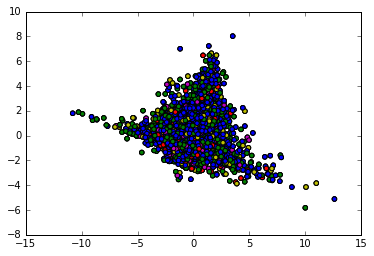

In [142]:
plt.scatter(X_new[:,0], X_new[:,1], c=colors)
plt.show()

# 4. Ensemble Classifiers for Multi-Class Answers <a class="anchor" id="4"></a>

In [182]:
def test_sklearn_model(model):
    model.fit(X_train, y_train * 4)
    print('Model Score:', model.score(X_test, y_test * 4))
    table = precision_recall_fscore_support(y_test * 4, model.predict(X_test))
    print('Precision:', table[0], np.mean(table[0]))
    print('Recall:   ', table[1], np.mean(table[1]))
    print('F1 Score: ', table[2], np.mean(table[2]))
    print('Support:  ', table[3])
    print('Confusion Matrix:')
    print(confusion_matrix(y_test * 4, model.predict(X_test)))

## 4.1. Random Forest Classifier <a class="anchor" id="41"></a>

In [191]:
test_sklearn_model(RandomForestClassifier(n_estimators=1000, max_depth=1000))

Model Score: 0.708354689903
Precision: [ 0.88        0.95384615  0.85416667  0.61781609  0.73180077] 0.80752593575
Recall:    [ 0.52380952  0.49206349  0.42051282  0.73504274  0.7950052 ] 0.593286754868
F1 Score:  [ 0.65671642  0.64921466  0.56357388  0.67135051  0.76209476] 0.660590046253
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[ 44   0   0  18  22]
 [  0  62   4  19  41]
 [  0   0  82  45  68]
 [  3   1   2 430 149]
 [  3   2   8 184 764]]


**Saving Best Model**

In [199]:
import pickle
clf = RandomForestClassifier(n_estimators=1000, max_depth=1000)
clf.fit(X_train, y_train * 4)
pickle.dump(clf, open('model.pkl', 'wb'))

## 4.2. Bagging Classifier <a class="anchor" id="42"></a>

In [192]:
test_sklearn_model(BaggingClassifier(n_estimators=1000))

Model Score: 0.707329574577
Precision: [ 0.88        0.96825397  0.82653061  0.61794501  0.73117255] 0.804780426603
Recall:    [ 0.52380952  0.48412698  0.41538462  0.72991453  0.79812695] 0.590272520866
F1 Score:  [ 0.65671642  0.64550265  0.55290102  0.669279    0.76318408] 0.657516632754
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[ 44   0   0  21  19]
 [  0  61   5  17  43]
 [  0   1  81  44  69]
 [  3   0   4 427 151]
 [  3   1   8 182 767]]


## 4.3. Ada Boost Classifier <a class="anchor" id="43"></a>

In [185]:
test_sklearn_model(AdaBoostClassifier(n_estimators=1000, learning_rate=0.9))

Model Score: 0.443362378268
Precision: [ 0.15384615  0.07692308  0.25714286  0.3279483   0.51140834] 0.265453746304
Recall:    [ 0.02380952  0.00793651  0.04615385  0.34700855  0.67637877] 0.220257439404
F1 Score:  [ 0.04123711  0.01438849  0.07826087  0.3372093   0.58243728] 0.210706610097
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[  2   0   1  33  48]
 [  1   1   0  40  84]
 [  2   1   9  62 121]
 [  3   1  10 203 368]
 [  5  10  15 281 650]]


## 4.4. Extra Trees Classifier <a class="anchor" id="44"></a>

In [186]:
test_sklearn_model(ExtraTreesClassifier(n_estimators=1000))

Model Score: 0.703229113275
Precision: [ 0.8627451   0.88732394  0.74545455  0.61730205  0.73481196] 0.769527519502
Recall:    [ 0.52380952  0.5         0.42051282  0.71965812  0.79292404] 0.591380900288
F1 Score:  [ 0.65185185  0.63959391  0.53770492  0.66456196  0.76276276] 0.651295079731
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[ 44   0   0  19  21]
 [  0  63   5  20  38]
 [  0   1  82  48  64]
 [  3   1   8 421 152]
 [  4   6  15 174 762]]


## 4.5. Gradient Boosting Classifier <a class="anchor" id="45"></a>

In [187]:
test_sklearn_model(GradientBoostingClassifier(n_estimators=1000, max_depth=1000))

Model Score: 0.691440287032
Precision: [ 0.74576271  0.7804878   0.6         0.61158192  0.75259875] 0.698086238049
Recall:    [ 0.52380952  0.50793651  0.43076923  0.74017094  0.75338189] 0.591213619309
F1 Score:  [ 0.61538462  0.61538462  0.50149254  0.66976025  0.75299012] 0.631002427035
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[ 44   2   0  15  23]
 [  0  64   8  21  33]
 [  1   3  84  49  58]
 [  7   5  16 433 124]
 [  7   8  32 190 724]]


## 4.6. SVM <a class="anchor" id="46"></a>

In [188]:
test_sklearn_model(sklearn.svm.SVC(gamma=10))

Model Score: 0.662224500256
Precision: [ 0.92        1.          0.96296296  0.60355987  0.66282895] 0.829870356176
Recall:    [ 0.27380952  0.3015873   0.26666667  0.63760684  0.83870968] 0.463676001418
F1 Score:  [ 0.42201835  0.46341463  0.41767068  0.62011638  0.74046853] 0.532737715182
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[ 23   0   0  24  37]
 [  0  38   1  26  61]
 [  0   0  52  42 101]
 [  0   0   1 373 211]
 [  2   0   0 153 806]]


## 4.7. Decision Tree Classifier <a class="anchor" id="47"></a>

In [189]:
test_sklearn_model(sklearn.tree.DecisionTreeClassifier())

Model Score: 0.657611481292
Precision: [ 0.52222222  0.48550725  0.5         0.59071118  0.78356481] 0.576401091806
Recall:    [ 0.55952381  0.53174603  0.43589744  0.6957265   0.70447451] 0.585473655723
F1 Score:  [ 0.54022989  0.50757576  0.46575342  0.6389325   0.74191781] 0.578881874317
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[ 47   3   4  18  12]
 [  2  67   6  23  28]
 [  5  10  85  52  43]
 [ 18  27  29 407 104]
 [ 18  31  46 189 677]]


## 4.8. K-Neighbours Classifier <a class="anchor" id="48"></a>

In [190]:
test_sklearn_model(KNeighborsClassifier(n_neighbors=5))

Model Score: 0.44951307022
Precision: [ 0.29545455  0.2         0.19428571  0.39479905  0.5955335 ] 0.336014562575
Recall:    [ 0.1547619   0.12698413  0.17435897  0.57094017  0.49947971] 0.305304977136
F1 Score:  [ 0.203125    0.15533981  0.18378378  0.46680643  0.54329372] 0.310469747369
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[ 13   1   6  33  31]
 [  2  16  14  41  53]
 [  1   7  34  84  69]
 [ 14  22  42 334 173]
 [ 14  34  79 354 480]]


## 4.9. Radius Neighbours Classifier <a class="anchor" id="49"></a>

In [196]:
test_sklearn_model(sklearn.neighbors.RadiusNeighborsClassifier(outlier_label=4))

Model Score: 0.471040492055
Precision: [ 0.54545455  0.26315789  0.26666667  0.36534447  0.51345609] 0.39081593303
Recall:    [ 0.07142857  0.03968254  0.04102564  0.2991453   0.75442248] 0.241140905574
F1 Score:  [ 0.12631579  0.06896552  0.07111111  0.32894737  0.61104088] 0.241276132555
Support:   [ 84 126 195 585 961]
Confusion Matrix:
[[  6   0   2  21  55]
 [  0   5   5  29  87]
 [  0   3   8  42 142]
 [  3   2   2 175 403]
 [  2   9  13 212 725]]


## 5. Building the Chatbot <a class="anchor" id="5"></a>

## 5.1. Applying the Model to All Unlabelled Replies <a class="anchor" id="49"></a>

In [1]:
import nltk.data
import subprocess

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import nltk
import gensim

print('Loading Merged DF...')

df = pd.read_json('merged_forum_threads.json')

print('Loaded Merged DF...')

titles_with_first_post = df.groupby('Link').first().reset_index()[['Link', 'Title', 'Username', 'Message', 'Replies']]
titles_with_first_post.columns = ['Link', 'Title', 'Seeker', 'First_Post', 'Replies']

def tokenize_properly(text):
    return [sent for sent in tokenizer.tokenize(text.replace('\n', '. '))
            if len(sent.replace('.', '').replace(' ', '')) >= 2]

print('Tokenizing...')

titles_with_first_post.Title = titles_with_first_post.Title.apply(tokenize_properly)
titles_with_first_post.First_Post = titles_with_first_post.First_Post.apply(tokenize_properly)

titles_with_first_post['Title_sent_count'] = titles_with_first_post.Title.apply(len)
titles_with_first_post['FP_sent_count'] = titles_with_first_post.First_Post.apply(len)

print('Tokenized. Loading Sent2Vec...')

sent2vecs = [[float(number) for number in line.strip().split(' ')] for line in open('all_title_fp_sent2vec.txt', 'r').readlines()]

print('Loaded Sent2Vec...')

title_vecs = {}
fp_vecs = {}
current = 0
for index, row in titles_with_first_post.iterrows():
    title_sent_count = row['Title_sent_count']
    fp_sent_count = row['FP_sent_count']
    title_vecs[index] = sent2vecs[current:current+title_sent_count]
    current += title_sent_count
    fp_vecs[index] = sent2vecs[current:current+fp_sent_count]
    current += fp_sent_count

titles_with_first_post['Title_sent2vec'] = pd.Series(titles_with_first_post.index.values).map(title_vecs)
titles_with_first_post['FP_sent2vec'] = pd.Series(titles_with_first_post.index.values).map(fp_vecs)

print('Added Sent2Vec. Adding Replies...')

titles_with_messages = pd.merge(titles_with_first_post.drop(['Replies'], axis=1), df[['Username', 'Message', 'Link', 'User Level', 'Posts']], on='Link')
titles_with_messages.rename(columns={'Username':'Replier', 'Posts': 'User Posts'}, inplace=True)
titles_with_messages = titles_with_messages[titles_with_messages.apply(lambda row: not row['First_Post'] == row['Message'] and not row['Seeker'] == row['Replier'], axis=1)]
titles_with_messages.Message = titles_with_messages.Message.apply(tokenize_properly)
titles_with_messages.rename(columns={'Message': 'Reply'}, inplace=True)
titles_with_messages['Reply_sent_count'] = titles_with_messages.Reply.apply(len)

print('Added Replies. Loading Sent2Vec...')

sent2vecs = [[float(number) for number in line.strip().split(' ')] for line in open('all_reply_sent2vec.txt', 'r').readlines()]

print('Loaded, Adding Sent2Vec...')

reply_vecs = []
current = 0
for index, row in titles_with_messages.iterrows():
    reply_sent_count = row['Reply_sent_count']
    reply_vecs.append(sent2vecs[current:current+reply_sent_count])
    current += reply_sent_count
titles_with_messages['Reply_sent2vec'] = reply_vecs

print('Added Sent2Vec...')

def is_not_null(sent_vec):
    for element in sent_vec:
        if not element == 0.0:
            return True
    return False

def sent_to_text_similarity(sent_vec, text_vec):
    similarities = []
    for vec in text_vec:
        if is_not_null(vec):
            similarities.append(np.dot(sent_vec, vec))
    if similarities:
        return np.mean(similarities)
    else:
        return np.nan

def text_to_text_similarity(sent_vecs1, sent_vecs2):
    similarities = []
    for v1 in sent_vecs1:
        if is_not_null(v1):
            similarity = sent_to_text_similarity(v1, sent_vecs2)
            if not np.isnan(similarity):
                similarities.append(similarity)
    if similarities:
        return np.mean(similarities)
    else:
        return np.nan

def text_to_corpus_similarity(text, corpus):
    sent_vecs = text_to_sent_vec(text)
    corpus_vecs = [text_to_sent_vec(other_text) for other_text in corpus]
    max_sim = 0
    index = -1
    for text_index in range(len(corpus_vecs)):
        similarity = text_to_text_similarity(sent_vecs, corpus_vecs[text_index])
        if not np.isnan(similarity) and max_sim < similarity:
            max_sim = similarity
            index = text_index
    if index >= 0:
        return corpus[index]
    else:
        return None

#print('Saving to JSON...')

#titles_with_messages.to_json('titles_with_messages.json')

Loading Merged DF...
Loaded Merged DF...
Tokenizing...
Tokenized. Loading Sent2Vec...
Loaded Sent2Vec...
Added Sent2Vec. Adding Replies...
Added Replies. Loading Sent2Vec...
Loaded, Adding Sent2Vec...
Added Sent2Vec...
Computing Features...


KeyError: ('First_Post_sent2vec', 'occurred at index 1')

In [2]:
print('Computing Features...')

titles_with_messages['Sim_Title_Reply'] = titles_with_messages.apply(
    lambda row: text_to_text_similarity(row['Title_sent2vec'],row['Reply_sent2vec'])
    if type(row['Reply_sent2vec']) == type([1]) else np.nan, axis=1)

titles_with_messages['Sim_Title_FP_Reply'] = titles_with_messages.apply(
    lambda row: text_to_text_similarity(row['FP_sent2vec'] + [row['Title_sent2vec']],row['Reply_sent2vec'])
    if type(row['Reply_sent2vec']) == type([1]) else np.nan, axis=1)

titles_with_messages['Sim_FP_Reply'] = titles_with_messages.apply(
    lambda row: text_to_text_similarity(row['FP_sent2vec'],row['Reply_sent2vec'])
    if type(row['Reply_sent2vec']) == type([1]) else np.nan, axis=1)

titles_with_messages['Reply_Length'] = titles_with_messages.Reply.apply(lambda message: len(' '.join(message)) if not type(message) == float else 0)

titles_with_messages['User Posts'] = titles_with_messages['User Posts'].apply(lambda x: float(x.replace(',','')) if type(x) == str else 1)

print('Standardising Features...')

user_level_mean = titles_with_messages['User Level'].mean()

def standardize(column):
    x_mean = column.mean()
    x_std = column.std()
    return (column.fillna(value=x_mean) - x_mean)/x_std

FEATURES = ['Sim_Title_Reply', 'Sim_Title_FP_Reply',
            'Sim_FP_Reply', 'Reply_Length', 'Reply_sent_count',
            'User Level', 'User Posts']

for feature in FEATURES:
    titles_with_messages[feature] = standardize(titles_with_messages[feature])

print('Predicting with Model...')

import pickle
from sklearn.ensemble import RandomForestClassifier
clf = pickle.load(open('model.pkl', 'rb'))
X = titles_with_messages[FEATURES]
titles_with_messages['Usefulness'] = clf.predict(X)

print('Predicted with Model.')

Computing Features...
Standardising Features...
Predicting with Model...
Predicted with Model.


In [3]:
titles_with_messages.head()

,Link,Title,Seeker,First_Post,Title_sent_count,FP_sent_count,Title_sent2vec,FP_sent2vec,Replier,Reply,User Level,User Posts,Reply_sent_count,Reply_sent2vec,Sim_Title_Reply,Sim_Title_FP_Reply,Sim_FP_Reply,Reply_Length,Usefulness
1,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Nuttdan,"[I hate mirrors., They remind me how crummy I ...",0.367785,-0.387636,-0.446793,"[[0.020335, -0.045285, 0.0068728, 0.0064149, -...",0.111477,1.661545,1.660984,-0.538998,4.0
2,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Rogue,[Quote:I've found that I tend to have about a ...,-1.661479,-0.410385,-0.446793,"[[0.0053239, 0.0092477, -0.012076, -0.0088438,...",1.989944,0.751713,0.117104,-0.264240,3.0
3,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",TyroneShoelaces,"[Like you, I have a lot of trouble staying in ...",-1.154163,-0.401160,0.347739,"[[0.0101, -0.013583, 0.0044502, -0.02776, 0.01...",0.739014,0.291466,0.026274,0.046737,4.0
4,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",alex,[Rogue wrote:My guess would be that it's not a...,23.704330,0.362878,-0.579215,"[[-0.0075652, -0.0032049, -0.0053176, -0.00444...",3.838123,1.246859,0.057298,-0.332929,4.0
5,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",Mich,[animallover wrote:All of you that don't have ...,0.000000,-0.373173,0.215317,"[[0.0012997, 0.0078113, -0.002381, 0.0056695, ...",0.933444,1.159144,0.875974,0.264046,4.0


In [4]:
titles_with_messages.Usefulness.value_counts()

4.0    347248
3.0    251856
1.0      2844
2.0       962
0.0       275
Name: Usefulness, dtype: int64

In [5]:
titles_with_messages.columns

Index(['Link', 'Title', 'Seeker', 'First_Post', 'Title_sent_count',
       'FP_sent_count', 'Title_sent2vec', 'FP_sent2vec', 'Replier', 'Reply',
       'User Level', 'User Posts', 'Reply_sent_count', 'Reply_sent2vec',
       'Sim_Title_Reply', 'Sim_Title_FP_Reply', 'Sim_FP_Reply', 'Reply_Length',
       'Usefulness'],
      dtype='object')

In [6]:
len(titles_with_messages)

603185

In [16]:
CHOSEN_COLUMNS = ['Link', 'Reply', 'Usefulness']
titles_with_messages[CHOSEN_COLUMNS].head()

,Link,Reply,Usefulness
1,60,"[I hate mirrors., They remind me how crummy I ...",4.0
2,60,[Quote:I've found that I tend to have about a ...,3.0
3,60,"[Like you, I have a lot of trouble staying in ...",4.0
4,60,[Rogue wrote:My guess would be that it's not a...,4.0
5,60,[animallover wrote:All of you that don't have ...,4.0


In [17]:
titles_with_messages[CHOSEN_COLUMNS].to_csv('all_replies.csv')

In [27]:
msg_df = titles_with_messages[CHOSEN_COLUMNS]
msg_df.head()

,Link,Reply,Usefulness
1,60,"[I hate mirrors., They remind me how crummy I ...",4.0
2,60,[Quote:I've found that I tend to have about a ...,3.0
3,60,"[Like you, I have a lot of trouble staying in ...",4.0
4,60,[Rogue wrote:My guess would be that it's not a...,4.0
5,60,[animallover wrote:All of you that don't have ...,4.0


In [15]:
titles_with_first_post.head()

,Link,Title,Seeker,First_Post,Replies,Title_sent_count,FP_sent_count,Title_sent2vec,FP_sent2vec
0,60,[Is this an asperger's trait?],animallover,[All of you that don't have jobs and the abili...,27,1,4,"[[-0.026278, -0.018632, -0.010761, 0.020232, -...","[[0.0012997, 0.0078113, -0.002381, 0.0056695, ..."
1,61,[Online Social Skills Education?],TyroneShoelaces,"[Hello Everyone., At present, I am in the proc...",22,1,8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,63,[Chat?],IrishWolf,"[Are there set times for chat?, It's just ever...",8,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.0080967, -0.046131, 0.014837, -0.018551, ..."
3,66,[Do you like Insects?],TyroneShoelaces,[To tell you the truth - I'm not much an insec...,47,1,2,"[[-0.017121, 0.0075421, -0.021786, 0.016274, 0...","[[-0.011399, 0.002861, 0.0030487, 0.010823, -0..."
4,99,"[Asperger's?, Only in my vocabulary for 3 days...",focused,"[I am 28 years old and just got the news., How...",25,3,18,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.011724, -0.016215, -0.012698, -0.0047712,..."


In [18]:
titles_with_first_post[['Link', 'Title', 'First_Post']].to_csv('all_titles_fp.csv')

In [28]:
tfp_df = titles_with_first_post[['Link', 'Title', 'First_Post']]
tfp_df.head()

,Link,Title,First_Post
0,60,[Is this an asperger's trait?],[All of you that don't have jobs and the abili...
1,61,[Online Social Skills Education?],"[Hello Everyone., At present, I am in the proc..."
2,63,[Chat?],"[Are there set times for chat?, It's just ever..."
3,66,[Do you like Insects?],[To tell you the truth - I'm not much an insec...
4,99,"[Asperger's?, Only in my vocabulary for 3 days...","[I am 28 years old and just got the news., How..."


## 5.2. Precomputing word2vec <a class="anchor" id="52"></a>

In [20]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
from nltk.corpus import stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

def get_sentence_vector(sentence):
    tokens = [token for token in nltk.word_tokenize(sentence) if token not in stopwords]
    vectors = []
    for token in tokens:
        try:
            word_vec = model.wv[token]
            vectors.append(word_vec)
        except:
            pass
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return []

In [29]:
tfp_df['Title_word2vec'] = tfp_df.Title.apply(lambda sents: [get_sentence_vector(sent) for sent in sents])
tfp_df['First_Post_word2vec'] = tfp_df.First_Post.apply(lambda sents: [get_sentence_vector(sent) for sent in sents])
tfp_df.head()

/Users/Khalil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Khalil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Link,Title,First_Post,Title_word2vec,First_Post_word2vec
0,60,[Is this an asperger's trait?],[All of you that don't have jobs and the abili...,"[[0.121663, 0.0303548, -0.0671387, 0.249674, -...","[[0.064051, 0.074655, -0.0577895, 0.138198, -0..."
1,61,[Online Social Skills Education?],"[Hello Everyone., At present, I am in the proc...","[[0.0338745, -0.101135, 0.145386, -0.20874, 0....","[[-0.0499268, 0.0224609, -0.0239868, 0.0745239..."
2,63,[Chat?],"[Are there set times for chat?, It's just ever...","[[-0.0854492, 0.123047, -0.0412598, 0.145508, ...","[[0.0261917, 0.158264, -0.0190582, 0.170044, 0..."
3,66,[Do you like Insects?],[To tell you the truth - I'm not much an insec...,"[[0.191081, 0.122233, 0.00389099, 0.156097, -0...","[[0.120117, 0.0454521, 0.0491943, 0.0600586, -..."
4,99,"[Asperger's?, Only in my vocabulary for 3 days...","[I am 28 years old and just got the news., How...","[[0.170898, -0.283203, -0.296875, 0.392578, -0...","[[0.0266602, 0.0945496, -0.00478516, -0.001123..."


In [31]:
msg_df['Reply_word2vec'] = msg_df.Reply.apply(lambda sents: [get_sentence_vector(sent) for sent in sents])
msg_df.head()

/Users/Khalil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Link,Reply,Usefulness,Reply_word2vec
1,60,"[I hate mirrors., They remind me how crummy I ...",4.0,"[[0.136719, 0.0665182, 0.149251, 0.098348, -0...."
2,60,[Quote:I've found that I tend to have about a ...,3.0,"[[0.0297873, 0.0276773, 0.00529322, 0.110268, ..."
3,60,"[Like you, I have a lot of trouble staying in ...",4.0,"[[0.0877686, 0.0608025, -0.000738144, 0.129211..."
4,60,[Rogue wrote:My guess would be that it's not a...,4.0,"[[0.0807059, 0.012704, 0.0712891, 0.11363, -0...."
5,60,[animallover wrote:All of you that don't have ...,4.0,"[[0.065701, 0.0700633, -0.0568848, 0.126912, -..."


## 5.3. Dot Product Similarity Functions <a class="anchor" id="53"></a>

In [1]:
import pandas as pd
from os import listdir
import gensim
import numpy as np
import nltk
from nltk.corpus import stopwords
import ast
stopwords = set(nltk.corpus.stopwords.words('english'))

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [2]:
tfp_df = pd.read_pickle('tfp_df.pkl')
tfp_df.head()

,Link,Title,First_Post,Title_word2vec,First_Post_word2vec
0,60,Is this an asperger's trait?,[All of you that don't have jobs and the abili...,"[0.121663411458, 0.0303548177083, -0.067138671...","[[0.0640510110294, 0.074654971852, -0.05778952..."
1,61,Online Social Skills Education?,"[Hello Everyone., At present, I am in the proc...","[0.0338745117188, -0.101135253906, 0.145385742...","[[-0.0499267578125, 0.0224609375, -0.023986816..."
2,63,Chat?,"[Are there set times for chat?, It's just ever...","[-0.08544921875, 0.123046875, -0.041259765625,...","[[0.0261917114258, 0.158264160156, -0.01905822..."
3,66,Do you like Insects?,[To tell you the truth - I'm not much an insec...,"[0.191080729167, 0.122233072917, 0.00389099121...","[[0.1201171875, 0.0454521179199, 0.04919433593..."
4,99,Asperger's? Only in my vocabulary for 3 days. ...,"[I am 28 years old and just got the news., How...","[0.0485432942708, 0.0144856770833, 0.053985595...","[[0.02666015625, 0.0945495605469, -0.004785156..."


In [4]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))

def get_sentence_vector(sentence):
    tokens = [token for token in nltk.word_tokenize(sentence) if token not in stopwords]
    vectors = []
    for token in tokens:
        try:
            word_vec = model.wv[token]
            vectors.append(word_vec)
        except:
            pass
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return []

def is_not_null(sent_vec):
    for element in sent_vec:
        if not element == 0.0:
            return True
    return False

def sent_to_text_similarity(sent_vec, text_vec):
    similarities = []
    for vec in text_vec:
        if is_not_null(vec):
            similarities.append(np.dot(sent_vec, vec)/(np.linalg.norm(sent_vec) * np.linalg.norm(vec)))
    if similarities:
        return np.mean(similarities)
    else:
        return np.nan

def text_to_text_similarity(sent_vecs1, sent_vecs2):
    similarities = []
    for v1 in sent_vecs1:
        if is_not_null(v1):
            similarity = sent_to_text_similarity(v1, sent_vecs2)
            if not np.isnan(similarity):
                similarities.append(similarity)
    if similarities:
        return np.mean(similarities)
    else:
        return np.nan

def text_to_corpus_similarity(text, corpus):
    sent_vecs = text_to_sent_vec(text)
    corpus_vecs = [text_to_sent_vec(other_text) for other_text in corpus]
    max_sim = 0
    index = -1
    for text_index in range(len(corpus_vecs)):
        similarity = text_to_text_similarity(sent_vecs, corpus_vecs[text_index])
        if not np.isnan(similarity) and max_sim < similarity:
            max_sim = similarity
            index = text_index
    if index >= 0:
        return corpus[index]
    else:
        return None

## 5.4. Chatbot Functions <a class="anchor" id="54"></a>

In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [6]:
def compute_similarity(row, sent_vec):
    title_sim = 0
    title_word2vec = row['Title_word2vec']
    if len(title_word2vec) > 0:
        title_sim = cosine_similarity(sent_vec, title_word2vec)
    return title_sim

def compute_separate_similarity(row, sent_vecs):
    title_sim = 0
    title_word2vec = row['Title_word2vec']
    if len(title_word2vec) > 0:
        title_sim = np.dot(sent_vecs[0], title_word2vec)/(np.linalg.norm(sent_vecs[0])*np.linalg.norm(title_word2vec))
    fp_sim = text_to_text_similarity(sent_vecs[1:], row['First_Post_word2vec'])
    return title_sim + fp_sim

def compute_separate_similarity_no_question(row, sent_vecs):
    fp_sim = text_to_text_similarity(sent_vecs, row['First_Post_word2vec'])
    return fp_sim

def get_most_similar_title(sentences, sent_vecs):
    if sentences == 0:
        raise ValueError('Write something!')
    elif len(sentences) == 1:
        title_fp_sim = tfp_df.apply(lambda row: compute_similarity(row, sent_vecs[0]), axis=1)
    elif sentences[0].endswith('?'):
        title_fp_sim = tfp_df.apply(lambda row: compute_separate_similarity(row, sent_vecs), axis=1)
    else:
        title_fp_sim = tfp_df.apply(lambda row: compute_separate_similarity_no_question(row, sent_vecs), axis=1)
    return tfp_df.loc[title_fp_sim.idxmax()]

def get_response_sentences(sentences, sent_vecs, link, max_sentences):
    answer_df = pd.read_pickle('msg_df/msg_df_{}.pkl'.format(link))
    best_answer = answer_df.loc[answer_df[answer_df.Usefulness == max(answer_df.Usefulness)]
                                .Reply_word2vec.apply(lambda other_vecs: 
                                                      text_to_text_similarity(sent_vecs, other_vecs)).idxmax()]
    best_sentence_idx = np.argmax([sent_to_text_similarity(sent_vec, sent_vecs) for sent_vec in best_answer.Reply_word2vec])
    reply_sentences = ast.literal_eval(best_answer.Reply)
    if max_sentences <= 1:
        return reply_sentences[best_sentence_idx]
    else:
        context_sent_count = int((max_sentences - 1)/2)
        sent_count = len(reply_sentences)
        lower_bound = best_sentence_idx - context_sent_count
        upper_bound = best_sentence_idx + context_sent_count + 1
        return ' '.join(reply_sentences[max(0, lower_bound - max(0, upper_bound - sent_count)): 
                                        min(upper_bound + max(0, 0 - lower_bound) + ((max_sentences - 1) % 2), sent_count)])

def chatbot_answer(question, max_sentences=1):
    sentences = tokenizer.tokenize(question)
    sent_vecs = [get_sentence_vector(sent) for sent in sentences]
    most_similar_title = get_most_similar_title(sentences, sent_vecs)
    return get_response_sentences(sentences, sent_vecs, most_similar_title.Link, max_sentences)

An example...

In [93]:
chatbot_answer('My parents beat me! They are abusive to me.', max_sentences=3)

"there have been several times when we've seriously considered doing this......the stress of having a child that is out of control one minute, and passive the next is quite taxing...........don't feel bad for doing what you feel is best for your child~ if you truly cannot handle him at home, then the best thing for him would be a different environment that's medically supervised and they have round-the-clock supervision......my heart aches for you.....best of luck"